# 边缘检测
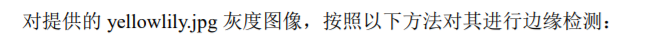

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def edgeDetection_sobel(img, d = 'x'):
    '''对图像img进行边缘检测，d=x,y,xy 分别检测水平方向、垂直方向、两个方向'''
    img_sobel = None
    # x方向上的算子模板为template，y方向上的算子模板求其转置矩阵即可
    template = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    if d == 'x':
        img_sobel = cv2.filter2D(img, -1, template)  # 自定义卷积
    elif d == 'y':
        template = template.T
        img_sobel = cv2.filter2D(img, -1, template)  # 图像矩阵和算子模板进行卷积操作
    else:
        sobelx = cv2.filter2D(img, -1, template)  # 自定义卷积
        sobely = cv2.filter2D(img, -1, template.T)  # 自定义卷积
        img_sobel = cv2.bitwise_or(sobelx, sobely)  # 或运算
    
    return img_sobel
    


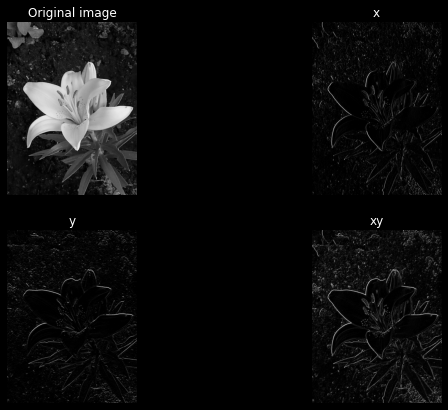

In [22]:
yello = cv2.imread('yellowlily.png',0)
sobel_x = edgeDetection_sobel(yello, 'x')
sobel_y = edgeDetection_sobel(yello, 'y')
sobel_xy = edgeDetection_sobel(yello, 'xy')

fig = plt.figure(figsize=(10,7))
plt.subplot(221), plt.title("Original image"), plt.axis('off')
plt.imshow(yello, cmap='gray')  # 原始图像
plt.subplot(222), plt.title("x"), plt.axis('off')
plt.imshow(sobel_x, cmap='gray')  
plt.subplot(223), plt.title("y"), plt.axis('off')
plt.imshow(sobel_y, cmap='gray')  
plt.subplot(224), plt.title("xy"), plt.axis('off')
plt.imshow(sobel_xy, cmap='gray') 
plt.show()

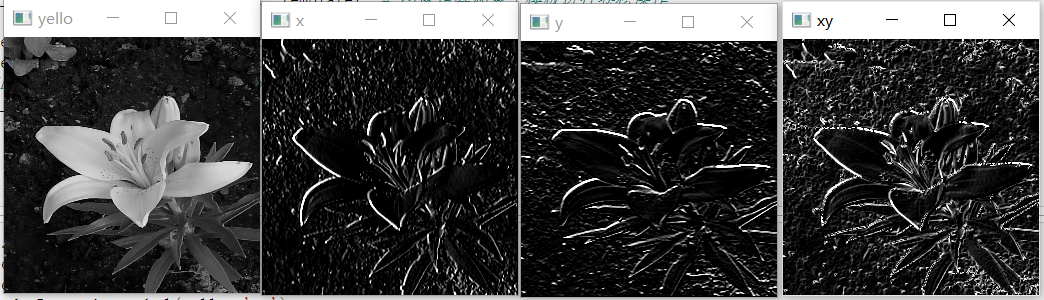

In [23]:
# kirsch 算子
def edgeDetection_kirsch(img):
    # 自定义卷积核，八个方向
    m1 = np.array([[-5, 3, 3], [-5, 0, 3], [-5, 3, 3]])
    m2 = np.array([[3, 3, 3], [-5, 0, 3], [-5, -5, 3]])
    m3 = np.array([[3, 3, 3], [3, 0, 3], [-5,-5,-5]])
    m4 = np.array([[3, 3, 3], [3, 0,-5], [3,-5,-5]])
    m5 = np.array([[3, 3, -5], [3, 0, -5], [3, 3, -5]])
    m6 = np.array([[3, -5, -5], [3, 0, -5], [3, 3, 3]])
    m7 = np.array([[-5, -5, -5], [3, 0, 3], [3, 3, 3]])
    m8 = np.array([[-5, -5, 3], [-5, 0, 3], [3, 3, 3]])

    template_l = [m1, m2, m3, m4, m5, m6, m7, m8]     # 将各个方向的卷积核放到一起便于统一操作
    # 建立三维数组（存放八个方向上的卷积的结果），第0维表示各个方向卷积后的值
    filtered_list = np.zeros((8, img.shape[0], img.shape[1]))   

    for k in range(8):
        out = cv2.filter2D(img, -1, template_l[k])   # 自定义卷积，其实里面的步骤跟Sobel算子是差不多的
        filtered_list[k] = out

    img_kirsch = np.max(filtered_list, axis = 0)  # 取八个方向中的最大值，也就是取第0维的最大值作为图像该点，滤波之后的新的像素值
    # 二值化，突出边缘
    img_kirsch[ np.where(img_kirsch >= 255)] = 255   # 令像素值大于255的点等于255
    img_kirsch[ np.where(img_kirsch < 255) ] = 0     # 令像素值小于255的点等于0
    return img_kirsch


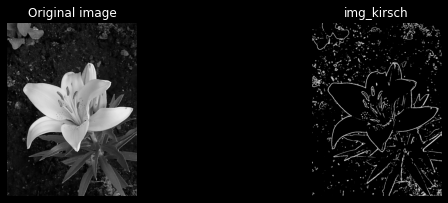

In [24]:
yello = cv2.imread('yellowlily.png',0)
img_kirsch = edgeDetection_kirsch(yello)

fig = plt.figure(figsize=(10,7))
plt.subplot(221), plt.title("Original image"), plt.axis('off')
plt.imshow(yello, cmap='gray')  # 原始图像
plt.subplot(222), plt.title("img_kirsch"), plt.axis('off')
plt.imshow(img_kirsch, cmap='gray')
plt.show()

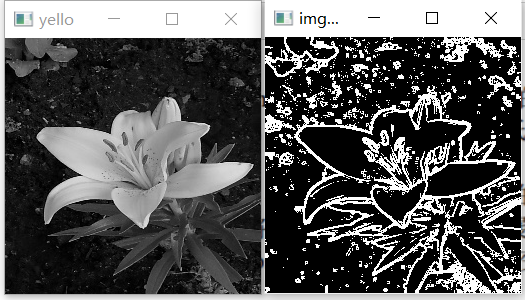

三个不同高、低阈值的Canny检测


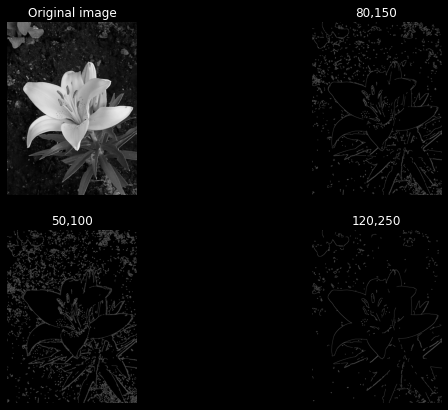

In [25]:
img=cv2.imread("yellowlily.png",cv2.IMREAD_GRAYSCALE)

print('三个不同高、低阈值的Canny检测')
v1=cv2.Canny(img,80,150)
v2=cv2.Canny(img,50,100)
v3=cv2.Canny(img,120,250)

fig = plt.figure(figsize=(10,7))
plt.subplot(221), plt.title("Original image"), plt.axis('off')
plt.imshow(img, cmap='gray')  # 原始图像
plt.subplot(222), plt.title("80,150"), plt.axis('off')
plt.imshow(v1, cmap='gray')  
plt.subplot(223), plt.title("50,100"), plt.axis('off')
plt.imshow(v2, cmap='gray')  
plt.subplot(224), plt.title("120,250"), plt.axis('off')
plt.imshow(v3, cmap='gray') 
plt.show()

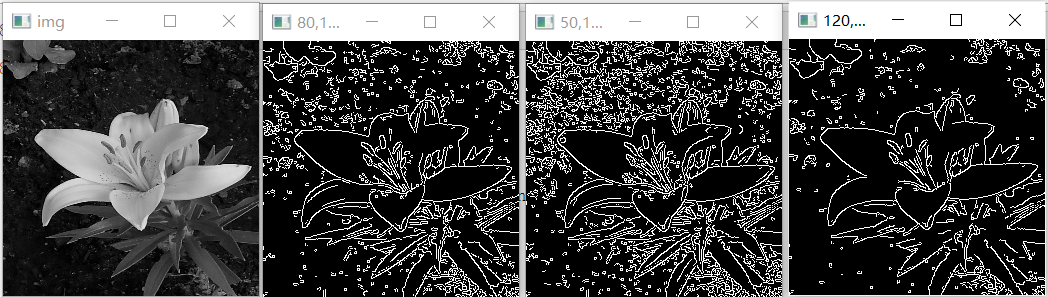

# 角点检测
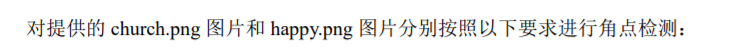

In [26]:
from scipy.ndimage import filters
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def compute_harris_response(img_,sigma=3):
    """ 在灰度图像img_中，对每个像素计算Harris 角点检测器响应函数"""
    # 计算导数
    img_x = np.zeros(img_.shape)
    filters.gaussian_filter(img_, (sigma,sigma), (0,1), img_x)
    img_y = np.zeros(img_.shape)
    filters.gaussian_filter(img_, (sigma,sigma), (1,0), img_y)
    # 计算Harris 矩阵的分量
    Wxx = filters.gaussian_filter(img_x*img_x,sigma)
    Wxy = filters.gaussian_filter(img_x*img_y,sigma)
    Wyy = filters.gaussian_filter(img_y*img_y,sigma)
    # 计算特征值和迹
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy
    return Wdet / Wtr

def get_harris_points(harrisim,min_dist=10,threshold=0.1):
    """ 从一幅Harris 响应图像中返回角点。min_dist 为分割角点和图像边界的最少像素数目"""
    # 寻找高于阈值的候选角点
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1
    # 得到候选点的坐标
    coords = np.array(harrisim_t.nonzero()).T
    # 以及它们的Harris 响应值
    candidate_values = [harrisim[c[0],c[1]] for c in coords]
    # 对候选点按照Harris 响应值进行排序
    index = np.argsort(candidate_values)
    # 将可行点的位置保存到数组中
    allowed_locations = np.zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
    # 按照min_distance 原则，选择最佳Harris 点
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist),(coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0
    return filtered_coords

def plot_harris_points(image,filtered_coords):
    """ 绘制图像中检测到的角点"""
    plt.figure()
    plt.gray()
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'*')
    plt.axis('off')
    plt.show()


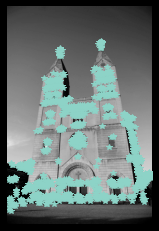

In [28]:
im = cv2.imread("church.png",cv2.IMREAD_GRAYSCALE)
harrisim = compute_harris_response(im)
filtered_coords = get_harris_points(harrisim,6)
plot_harris_points(im, filtered_coords)

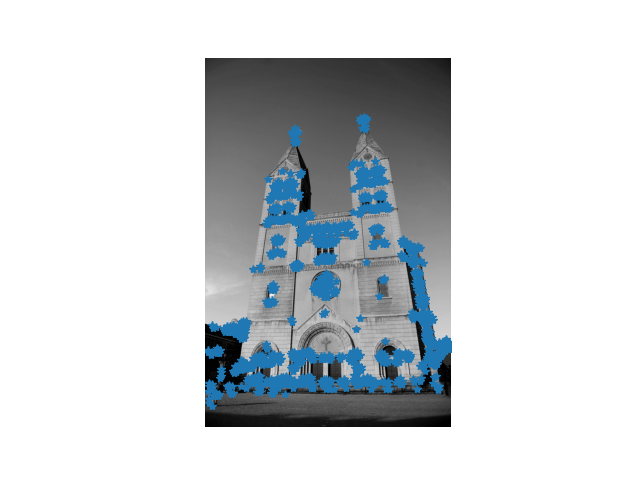

In [29]:
# 获取susan的卷积核，圆形模板
def get_susan_mask():
    mask=np.ones((7,7))
    for c in (0,1,5,6):
        mask[0,c] = 0
    for c in (0,6):
        mask[1,c] = 0
    for c in (0,6):
        mask[5,c] = 0
    for c in (0,1,5,6):
        mask[6,c] = 0
    return mask

def susan_corner_detect(img_src,t=10):
    susan_mask = get_susan_mask()  # 获取SUSAN模板（圆形模板）
    img = img_src.copy()
    row_s,col_s = 3,3
    row_e,col_e = img_src.shape[0]-3,img.shape[1]-3
    n_max = 0
    n_arr=37*np.ones(img.shape) # 初始认为没有角点
    for r in range(row_s,row_e):# 遍历所有行
        for c in range(col_s,col_e):  # 遍历所有列
            susan_zone = img[r-3:r+3+1,c-3:c+3+1]   # 获取矩形区域
            susan_zone = susan_zone[susan_mask!=0]  # 使用mask截取圆形区域
            r0 = img[r,c]
            # 平滑曲线函数计算“相似度”
            similarity = np.exp(-((1.0*susan_zone-r0)/t)**2 )
            # 累计相似度
            n=np.sum(similarity)
            if n>n_max:
                n_max = n
            n_arr[r,c] = n
    g = n_max /2
    R = np.zeros(img.shape)
    index = n_arr<g       # 小于g，认为是可能的角点，越小，可能性越大
    R[index] = g-n_arr[index] # 取反，所以R越大，是角点的可能性越大
    return R


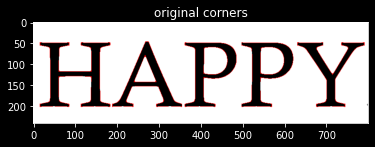

In [30]:
img_src = cv2.imread('happy.png',0)
corner = susan_corner_detect(img_src)

img_show = cv2.cvtColor(img_src, cv2.COLOR_GRAY2BGR)
img_show[corner != 0] = (255, 0, 0)
plt.figure()
plt.title("original corners")
plt.imshow(img_show)
plt.show()

第6题

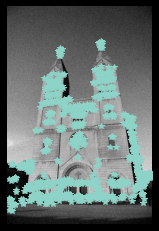

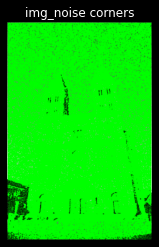

In [31]:
im = cv2.imread("church_noise.png",cv2.IMREAD_GRAYSCALE)
harrisim = compute_harris_response(im)
filtered_coords = get_harris_points(harrisim,6)
plot_harris_points(im, filtered_coords)

img_src = cv2.imread('church_noise.png',0)
corner = susan_corner_detect(img_src)

img_show = cv2.cvtColor(img_src, cv2.COLOR_GRAY2BGR)
img_show[corner != 0] = (0, 255, 0)  # 角点区域显示为绿色

plt.figure()
plt.title("img_noise corners")
plt.imshow(img_show)
plt.axis('off')
plt.show()